<a href="https://colab.research.google.com/github/mmichellesvv/color-blindless-approximation/blob/main/ColorBlindlessApprox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import shutil
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

In [4]:
def daltonizer(img, daltype):
    lms = np.array([[17.8824, 43.5161, 4.11935],
                    [3.45565, 27.1554, 3.86714],
                    [0.0299566, 0.184309, 1.46709]])

    lms_img = np.dot(img, lms.T)

    if daltype == 'protanopia':
        arr = np.array([[0, 2.02344, -2.52581],
                        [0, 1, 0],
                        [0, 0, 1]])
    elif daltype == 'deuteranopia':
        arr = np.array([[1, 0, 0],
                        [0.494207, 0, 1.24827],
                        [0, 0, 1]])
    elif daltype == 'tritanopia':
        arr = np.array([[1, 0, 0],
                        [0, 1, 0],
                        [-0.395913, 0.801109, 0]])
    elif daltype == 'monochromacy':
        arr = np.array([[0.299, 0.587, 0.114],
                        [0.299, 0.587, 0.114],
                        [0.299, 0.587, 0.114]])

        img_gray = np.dot(img[..., :3], [0.299, 0.587, 0.114])

        img_gray = img_gray[..., np.newaxis].astype(np.uint8)

        img_mono = np.concatenate([img_gray, img_gray, img_gray], axis=2)


        return img_mono

    else:
        arr = np.array([[1, 0, 0],
                        [0, 1, 0],
                        [0, 0, 1]])

    simulated_LMS = np.dot(lms_img, arr.T)

    inv_lms_arr = np.linalg.inv(lms)
    dalt_img = np.dot(simulated_LMS, inv_lms_arr.T)

    dalt_img = np.clip(dalt_img, 0, 255).astype(np.uint8)

    return dalt_img


In [28]:
cls = ['deuteranopia', 'protanopia', 'tritanopia', 'monochromacy']

for fp in cls:
  os.makedirs(f'/content/drive/MyDrive/lms_data/{fp}', exist_ok=True)


dp = '/content/drive/MyDrive/data'

names = os.listdir(dp)

class_images = {str(i): [] for i in range(10)}

for fn in os.listdir(dp):
    if fn[0].isdigit() and fn.endswith('.png'):
        class_images[fn[0]].append(fn)

for class_label, images in class_images.items():
    if len(images) >= 10:
        selected_images = random.sample(images, 10)
    else:
        selected_images = images

    for image_name in selected_images:
        src_path = os.path.join(dp, image_name)
        image = cv2.imread(src_path)

        for vision_type in cls:
            dalt_img = daltonizer(image, vision_type)
            dst_path = os.path.join(f'/content/drive/MyDrive/lms_data/{vision_type}', image_name)
            cv2.imwrite(dst_path, dalt_img)


In [57]:

set_img = tf.keras.preprocessing.image.ImageDataGenerator(shear_range=0.1, zoom_range=0.0, horizontal_flip=True, vertical_flip=False, rescale=1/255, validation_split=0.1)

dataset = set_img.flow_from_directory(directory='/content/drive/MyDrive/lms_data', target_size=(256, 256), classes=cls, class_mode='categorical', batch_size=16, shuffle=True, seed=30)



Found 400 images belonging to 4 classes.


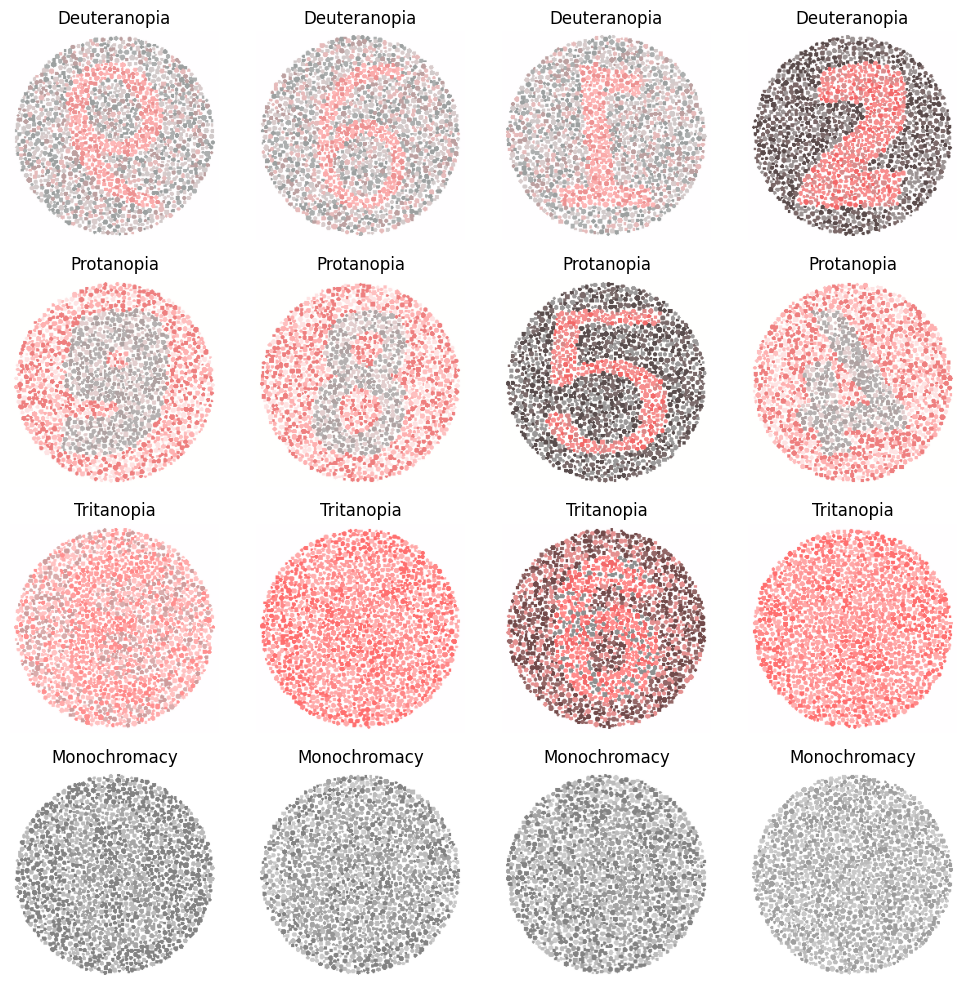

In [59]:
images_per_class = {c: [] for c in cls}

for images, labels in dataset:
    class_indices = np.argmax(labels, axis=1)
    for i, idx in enumerate(class_indices):
        cl = cls[idx]
        if len(images_per_class[cl]) < 4:
            images_per_class[cl].append(images[i])
        if all(len(images_per_class[cl]) >= 4 for cl in cls):
            break
    if all(len(images_per_class[cl]) >= 4 for cl in cls):
        break


fig, ax = plt.subplots(len(cls), 4, figsize=(10, 10))

for idx, c in enumerate(cls):
    for i in range(4):
        ax[idx, i].imshow(images_per_class[c][i])
        ax[idx, i].set_title(c.capitalize())
        ax[idx, i].axis('off')

plt.tight_layout()
plt.show()